# ClusterMap for STARmap V1_1020

In [1]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io
import math
from tqdm import tqdm

### Read spots and dapi image-BY3

In [2]:
### set file folder
filepath='./datasets/STARmap_V1_1020/BY3/'

### read dapi: col, row, z
dapi = tifffile.imread(filepath+'BY3_dapi.tiff')

### read spots
spots = pd.read_csv(filepath+'BY3_raw.csv')
spots.columns=['gene_name','spot_location_1','spot_location_2','spot_location_3']

### convert gene_name to gene identity
genes=pd.DataFrame(spots['gene_name'].unique())
a1=list(genes[0])
gene=list(map(lambda x: a1.index(x)+1, spots['gene_name']))
spots['gene']=gene
spots['gene']=spots['gene'].astype('int')

# ### save gene annotation as genelist.csv
genes.to_csv(filepath+'genelist.csv', header=False, index=False)

In [3]:
### set radius parameters
xy_radius=55

Text(0.5, 1.0, 'raw data')

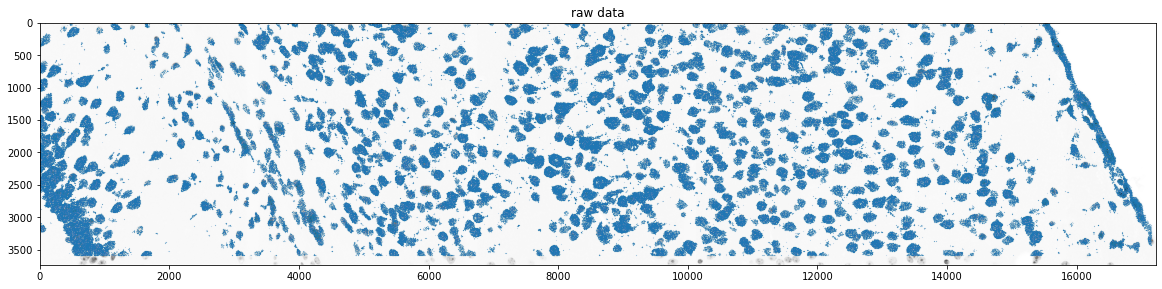

In [4]:
### overview
plt.figure(figsize=(20,20))
length=1000
plt.imshow(dapi,cmap='Greys')
plt.scatter(spots['spot_location_1'],spots['spot_location_2'],s=0.005)
plt.title('raw data')

### instantiate a model for all input data

In [5]:
num_gene=np.max(spots['gene'])

gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=True)

If cell segmentation was performed before, jump to *Perform cell typing (based on Scanpy package)* part.

### split data into small tiles if input is large

In [7]:
### trim
img = dapi
window_size=1500
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 36 tiles


Text(0.5, 1.0, 'splitted tile: 15')

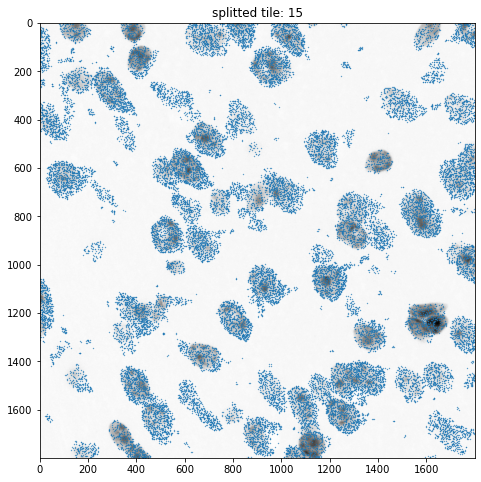

In [8]:
###plot a tile
tile_num=15
plt.figure(figsize=(8,8))
plt.imshow(out.loc[tile_num,'img'],cmap='Greys')

plt.scatter(out.loc[tile_num,'spots']['spot_location_1'],
            out.loc[tile_num,'spots']['spot_location_2'],s=0.1)
plt.title(f'splitted tile: {tile_num}')

### cell segmentation on each tile

In [122]:
%%time

### process each tile
pct_filter=0
model.spots['clustermap']=-1

for tile_num in range(out.shape[0]):
    print(f'tile: {tile_num}')
    spots_tile=out.loc[tile_num,'spots']
    dapi_tile=out.loc[tile_num,'img']

    ### instantiate model
    model_tile = ClusterMap(spots=spots_tile, dapi=dapi_tile, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=False)

    ###preprocessing
    model_tile.preprocess(dapi_grid_interval=3,pct_filter=pct_filter)

#     # ### segmentation
    model_tile.min_spot_per_cell=5
    model_tile.segmentation(cell_num_threshold=0.1,dapi_grid_interval=3,add_dapi=True,use_genedis=True)

    # ### plot cell segmentation results in spots (colored by cells)
    model_tile.plot_segmentation(figsize=(4,4),s=0.01,plot_with_dapi=True,plot_dapi=True, show=False)

    # ### stitch tiles together
    model.stitch(model_tile,out,tile_num)
    model.plot_segmentation(figsize=(30,15),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
    plt.show()

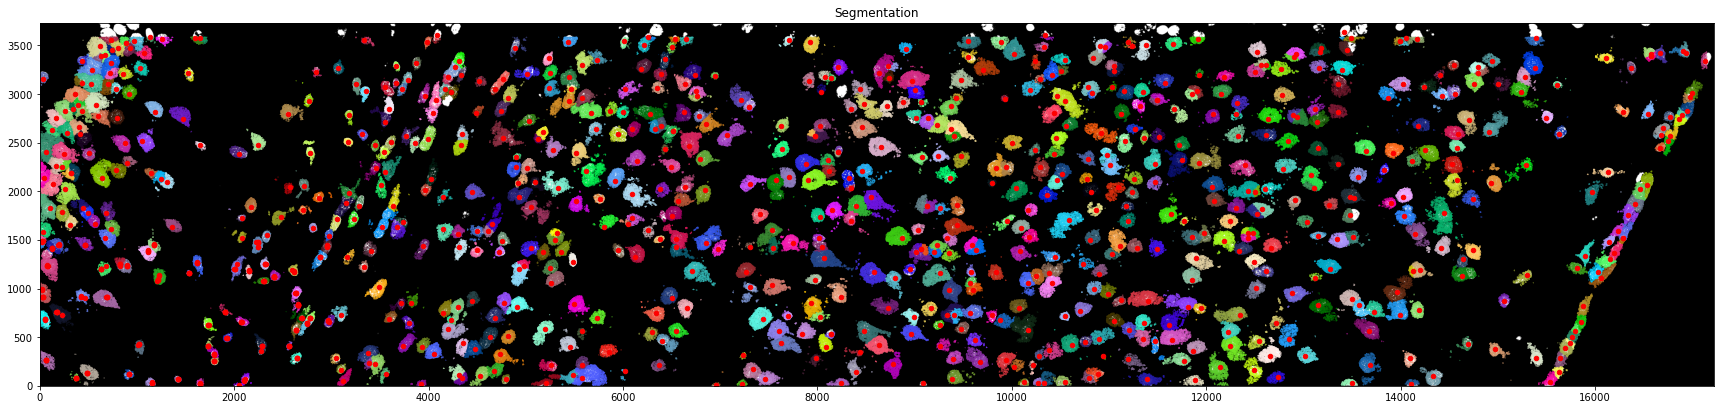

In [18]:
model.plot_segmentation(figsize=(30,15),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
plt.scatter(model.cellcenter_unique[:,1],model.cellcenter_unique[:,0],c='r',s=20)
plt.show()

### Save cell segmentation results

In [19]:
path_save = filepath+'spots_all.csv'
model.save_segmentation(path_save)

### Perform cell typing (based on Scanpy package)

In [32]:
###read in saved cell segmentation results
path_save = filepath+'spots_all.csv'
savespots=pd.read_csv(path_save)
model.spots=savespots

In [33]:
cellid='clustermap'
geneid='gene'
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

In [34]:
### create adata, saved in model.cell_adata
model.create_cell_adata(cellid,geneid,gene_list,genes,num_dims)

/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


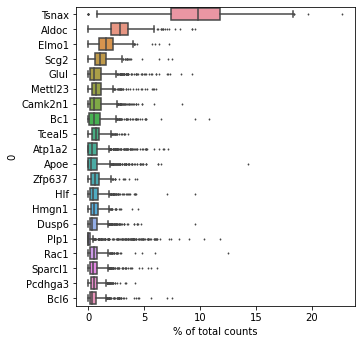

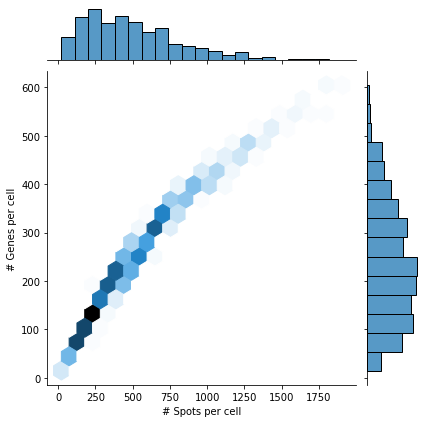

In [35]:
model.cell_preprocess()

Since the number of cells in one sample is relatively small, we apply a main-level to sub-level clustering strategy here to identify reliable cell types.

Main-level cluster

In [36]:
model.cell_typing(cluster_method='leiden',n_clusters=15,resol=1)

clustering method: leiden
Leiden clustering
Get 9 clusters


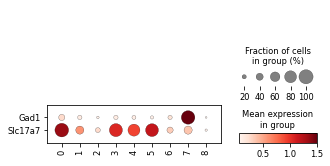

In [37]:
cluster_pl=model.plot_cell_typing(umap=False,
                                  heatmap=False,
                                  print_markers=False,
                                  celltypemap=False)
marker_genes=["Gad1","Slc17a7"]
sc.pl.dotplot(model.cell_adata, marker_genes, groupby='cell_type',swap_axes=True);

From the dotplot, we find that cluster 0,3,4,5 are Slc17a7 positive so we annotate them as excitatory neurons. Cluster 7 is Gad1 positive so we annotate it as inhibitory neuron.

In [38]:
merge_list = [[0,3,4,5],[1,2,6,8]]

model.merge_multiple_clusters(merge_list)

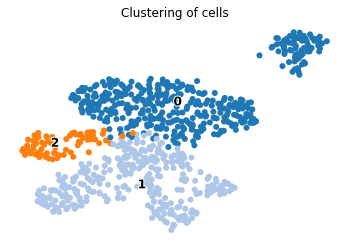

0 ['Pcsk2', 'Slc17a7', 'Pgm2l1', 'Arc', 'Arpp21']
1 ['Qk', 'Glul', 'Apod', 'Apoe', 'Plp1']
2 ['Gad1', 'Gad2', 'Scg2', 'Btbd11', 'Kcnc2']


/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:661: RuntimeWarning: invalid value encountered in true_divide
  return n_nonzero / X.shape[0]


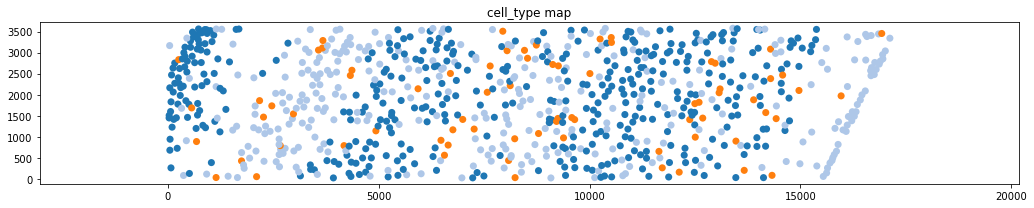

In [39]:
cluster_pl=model.plot_cell_typing(umap=True,
                                  heatmap=False, 
                                  print_markers=True)

Sub-level clustering

1. Excitatory neurons

In [40]:
model.exci_adata=model.cell_adata[model.cell_adata.obs['cell_type']==0,:]

In [41]:
model.cell_typing(use_adata=model.exci_adata,
                  cluster_method='leiden',
                  resol=1)

Trying to set attribute `.obs` of view, copying.


clustering method: leiden
Leiden clustering
Get 5 clusters


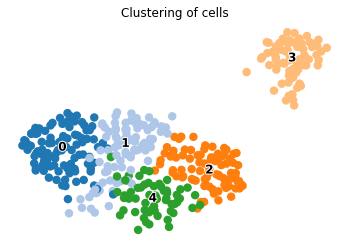

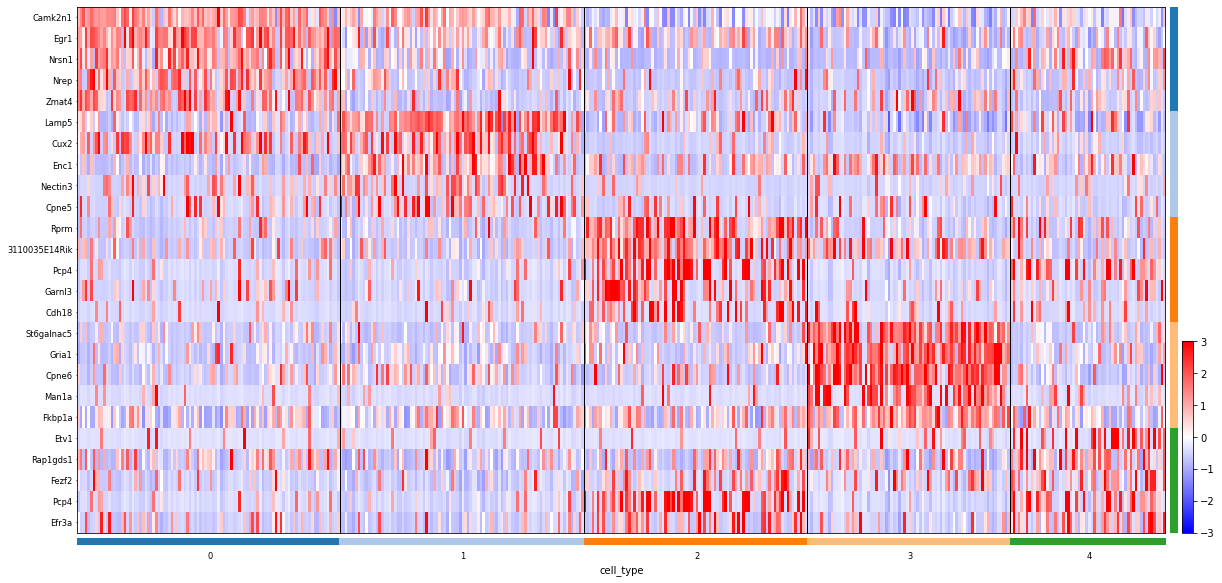

0 ['Camk2n1', 'Egr1', 'Nrsn1', 'Nrep', 'Zmat4']
1 ['Lamp5', 'Cux2', 'Enc1', 'Camk2n1', 'Nectin3']
2 ['Rprm', '3110035E14Rik', 'Pcp4', 'Garnl3', 'Cdh18']
3 ['St6galnac5', 'Gria1', 'Cpne6', 'Man1a', 'Fkbp1a']
4 ['Etv1', 'Rap1gds1', 'Fezf2', 'Slc20a1', 'Pcp4']


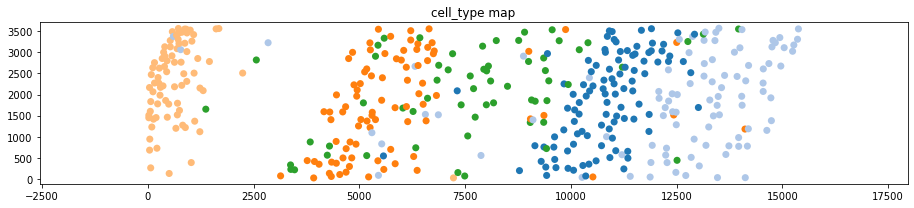

In [42]:
cluster_pl=model.plot_cell_typing(use_adata=model.exci_adata,
                                  umap=True,
                                  heatmap=True, 
                                  print_markers=True,
                                  celltypemap=True)


0: eL4
1: eL2/3
2: eL6
3: HPC
4: eL5

2. Inhibitory neurons

In [43]:
model.inhi_adata=model.cell_adata[model.cell_adata.obs['cell_type']==2,:]

In [44]:
model.cell_typing(use_adata=model.inhi_adata,
                  cluster_method='leiden',resol=0.9)

Trying to set attribute `.obs` of view, copying.


clustering method: leiden
Leiden clustering
Get 4 clusters


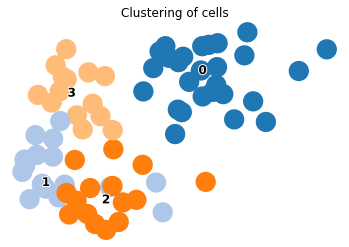

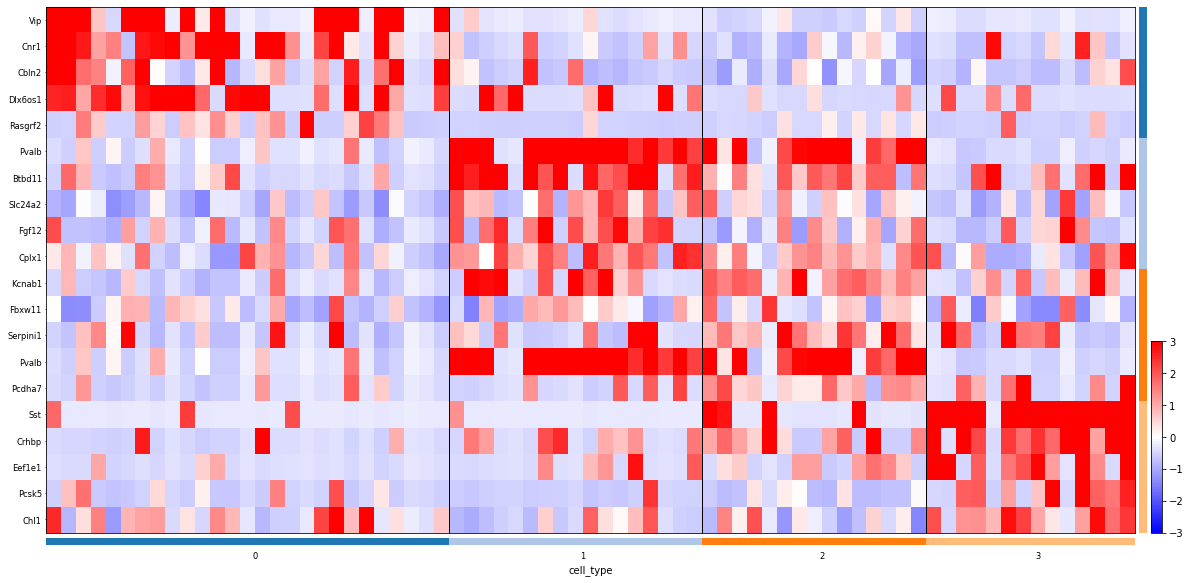

0 ['Vip', 'Cnr1', 'Cbln2', 'Dlx6os1', 'Rasgrf2']
1 ['Pvalb', 'Btbd11', 'Gad1', 'Slc24a2', 'Fgf12']
2 ['Kcnab1', 'Fbxw11', 'Serpini1', 'Pvalb', 'Pcdha7']
3 ['Sst', 'Crhbp', 'Eef1e1', 'Pcsk5', 'Chl1']


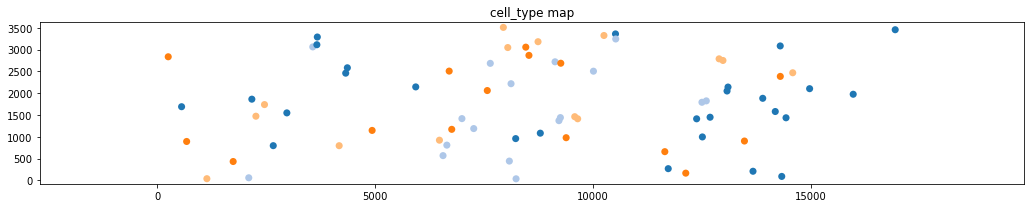

In [45]:
cluster_pl=model.plot_cell_typing(use_adata=model.inhi_adata,
                                  umap=True,
                                  heatmap=True, 
                                  print_markers=True,
                                  celltypemap=True)


3. Non-neuronal cells

In [46]:
model.nonn_adata=model.cell_adata[model.cell_adata.obs['cell_type']==1,:]

In [47]:
model.cell_typing(use_adata=model.nonn_adata,
                  cluster_method='leiden',resol=0.8)

Trying to set attribute `.obs` of view, copying.


clustering method: leiden
Leiden clustering
Get 4 clusters


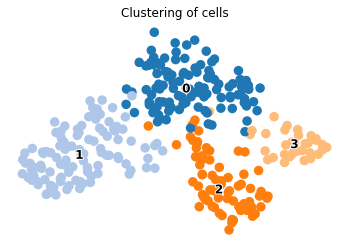

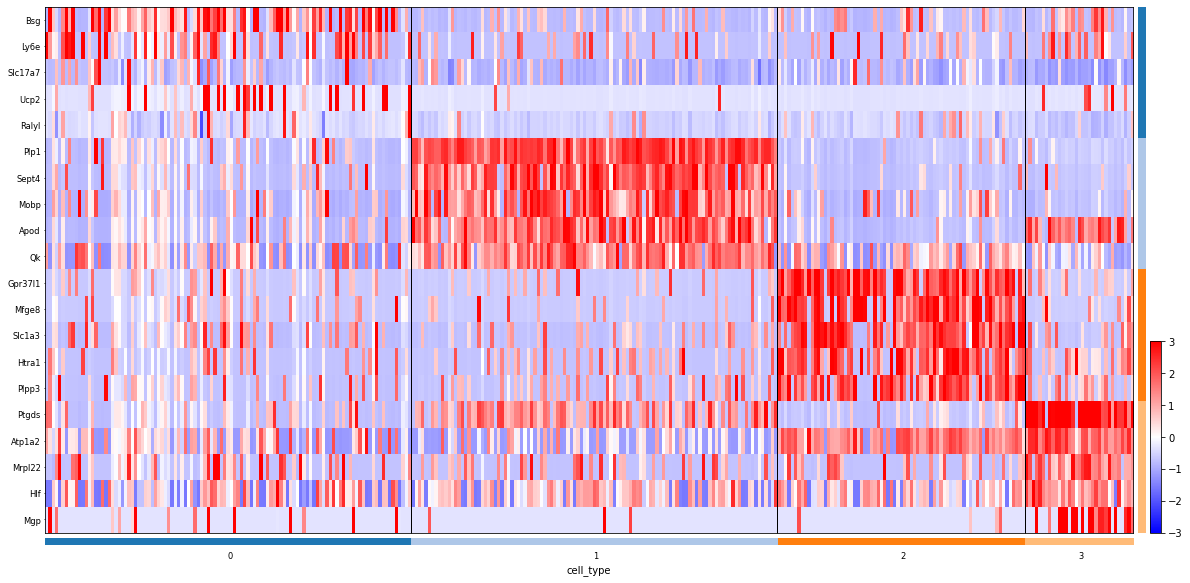

0 ['Bsg', 'Ly6e', 'Slc17a7', 'Ucp2', 'Ralyl']
1 ['Plp1', 'Sept4', 'Mobp', 'Apod', 'Qk']
2 ['Gpr37l1', 'Mfge8', 'Slc1a3', 'Htra1', 'Plpp3']
3 ['Ptgds', 'Atp1a2', 'Mrpl22', 'Hlf', 'Mgp']


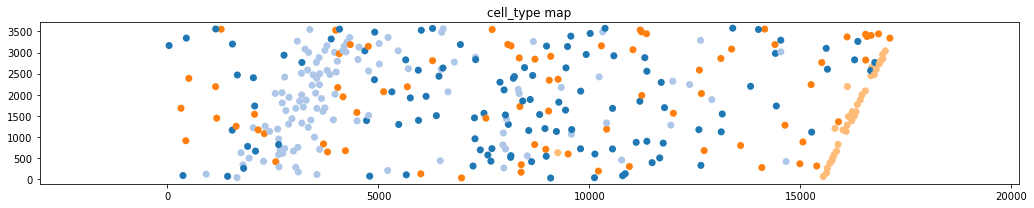

In [48]:
cluster_pl=model.plot_cell_typing(use_adata=model.nonn_adata,
                                  umap=True,
                                  heatmap=True, 
                                  print_markers=True,
                                  celltypemap=True)


In [49]:
###combine sub-clustering results
model.combine_cell_type([model.exci_adata,model.inhi_adata,model.nonn_adata])

In [50]:
model.map_cell_type_to_spots(cellid)

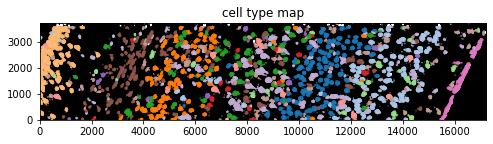

In [51]:
### plot cell segmentation results in spots (colored by cells)
cmap=sns.color_palette('tab20',20)
model.plot_segmentation(figsize=(8,8),method='cell_type',s=0.005,plot_with_dapi=True,plot_dapi=True, show=False,cmap=np.array(cmap))
plt.title('cell type map')
plt.show()

### Tissue region identification

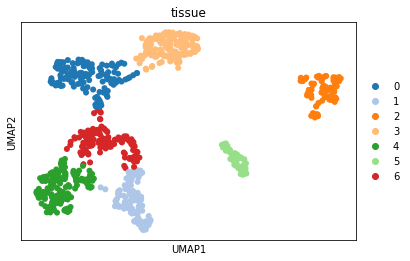

In [28]:
tissue_radius=400
model.compute_ncc(tissue_radius=tissue_radius)
model.tissue_identify(region=7,cmap=cmap)

In [29]:
model.tissue_refine()
model.map_cell_type_to_spots(cellid,target_name='tissue_id_refine')

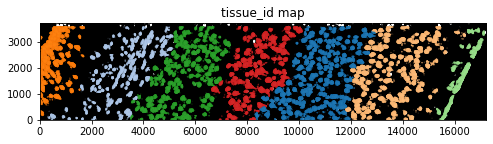

In [31]:
### plot tissue region results in spots (colored by cells)
model.plot_segmentation(figsize=(8,8),method='tissue_id_refine',s=0.005,plot_with_dapi=True,plot_dapi=True, show=False,
                       cmap=np.array(cmap))
plt.title('tissue_id map')
plt.show()